In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
#%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

#from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.3.1


In [4]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA

class PCAPlotter(tf.keras.callbacks.Callback):
    
    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(9, 4))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()
        
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
        
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)

**Data Preparation**

In [46]:
import pandas as pd

df=pd.read_csv('women_foot_wear.csv')
df.shape

In [46]:
df.head()

In [ ]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X=df.drop(['label'],axis=1)
y=df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [ ]:
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [ ]:
links_train=X_train['links']
links_test=X_test['links']
final_links_wfw=pd.concat([links_train,links_test],ignore_index=True)
final_links_wfw.to_csv('women_foot_wear_links.csv')

In [147]:
import pandas as pd

final_links_mtw=pd.read_csv('men_top_wear_links.csv')
final_links_mtw=final_links_mtw['links']
#final_links_mbw=final_links_mbw.to_list()

In [ ]:
from PIL import Image 
from numpy import asarray
from tqdm import tqdm

final_list_train=[]
final_list_test=[]

for i in tqdm(X_train['File Paths']):
    
    img = Image.open(i)
    img = img.resize((60,80),Image.ANTIALIAS)
    numpydata1 = asarray(img)
    final_list_train.append(numpydata1)

for i in tqdm(X_test['File Paths']):
    
    img = Image.open(i)
    img = img.resize((60,80),Image.ANTIALIAS)
    numpydata1 = asarray(img)
    final_list_test.append(numpydata1)

100%|██████████| 51/51 [00:21<00:00,  2.38it/s]


In [ ]:
final_array_train = np.stack(final_list_train)
final_array_test = np.stack(final_list_test)
final_array_train.shape

(450, 80, 60, 3)

In [ ]:
final_array_test.shape

(51, 80, 60, 3)

In [ ]:
x_train = np.reshape(final_array_train,(final_array_train.shape[0], 14400))/255.
x_test = np.reshape(final_array_test, (final_array_test.shape[0], 14400))/255.
print(x_train.shape)

(450, 14400)


In [ ]:
np.save('/content/gdrive/MyDrive/Train_array/x_train16', x_train)
np.save('/content/gdrive/MyDrive/Test_array/x_test16', x_test) 

In [ ]:
np.save('/content/gdrive/MyDrive/Train_array/y_train16', y_train)
np.save('/content/gdrive/MyDrive/Test_array/y_test16', y_test) 

In [148]:
import numpy as np

x_train = np.load('/content/gdrive/MyDrive/Train_array/x_train11.npy')
x_test = np.load('/content/gdrive/MyDrive/Test_array/x_test11.npy')

In [149]:
y_train = np.load('/content/gdrive/MyDrive/Train_array/y_train11.npy')
y_test = np.load('/content/gdrive/MyDrive/Test_array/y_test11.npy')

**Plotting** **Examples**

In [150]:
def plot_triplets(examples):
    plt.figure(figsize=(8, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (80, 60,3)))
        plt.xticks([])
        plt.yticks([])
    plt.show()

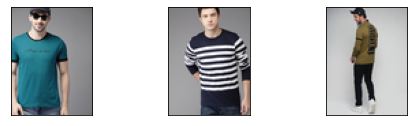

In [151]:
plot_triplets([x_train[0], x_train[75], x_train[179]])

**A Batch of Triplets**

In [152]:
def create_batch(batch_size=64):
    x_anchors = np.zeros((batch_size, 14400))
    x_positives = np.zeros((batch_size, 14400))
    x_negatives = np.zeros((batch_size, 14400))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(tf.where(y_train == y))
        indices_for_neg = np.squeeze(tf.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

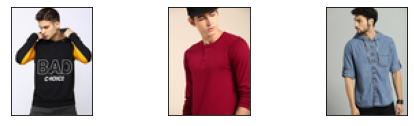

In [153]:
examples = create_batch(1)
plot_triplets(examples)

**Embedding Model**

In [154]:
emb_size = 1024

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(14400,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              14746624  
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
Total params: 15,796,224
Trainable params: 15,796,224
Non-trainable params: 0
_________________________________________________________________


In [155]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

[0.4409954  0.6137605  0.52984345 ... 0.5608096  0.4026061  0.47850353]


**Siamese Network**

In [156]:
input_anchor = tf.keras.layers.Input(shape=(14400,))
input_positive = tf.keras.layers.Input(shape=(14400,))
input_negative = tf.keras.layers.Input(shape=(14400,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 14400)]      0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 14400)]      0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 14400)]      0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1024)         15796224    input_16[0][0]                   
                                                                 input_17[0][0]             

**Triplet Loss**

In [157]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    lembedd=(tf.reduce_mean(tf.square(anchor),axis=1)+tf.reduce_mean(tf.square(positive),axis=1)+\
             tf.reduce_mean(tf.square(negative),axis=1))*1/(3*256)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)+lembedd

**Data Generator**

In [158]:
def data_generator(batch_size,emb_size):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

In [ ]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        loss = logs["loss"]
        if loss <= self.threshold:
            self.model.stop_training = True
my_callback = MyThresholdCallback(threshold=0.01)

**Model Training**

In [ ]:
import datetime

batch_size = 32
epochs = 700
steps_per_epoch = int(x_train.shape[0]/batch_size)
adam = tf.keras.optimizers.Adam(lr=0.0001,beta_1=0.9, beta_2=0.9, epsilon=1e-08)
#net.load_weights('/content/gdrive/My Drive/checkpoints1/net.hdf5')
net.compile(loss=triplet_loss, optimizer=adam)


_ = net.fit(
    data_generator(batch_size,emb_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, 
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test, y_test
        ),my_callback])
net.save_weights('/content/gdrive/My Drive/checkpoints1/net16.hdf5')

In [159]:
net.load_weights('/content/gdrive/My Drive/checkpoints1/net11.hdf5')

In [160]:
embedding_model.predict(example)[0]

array([0.7065136 , 0.6913104 , 0.353036  , ..., 0.29378593, 0.6378365 ,
       0.34915417], dtype=float32)

**Faiss Implementation for finding similar fashion products using embeddings**

In [ ]:
!pip install faiss-cpu

     |████████████████████████████████| 7.9MB 3.7MB/s 


In [ ]:
x=np.concatenate((x_train,x_test))
x.shape

(501, 14400)

In [ ]:
#Finding the similarities and storing them in gdrive
from tqdm import tqdm
import faiss 
vector_dimension=1024

index = faiss.IndexFlatL2(vector_dimension)
for i in x:
    image_array_a = np.reshape(i,(1, 14400))
    #ex_a=np.expand_dims(image_array_a, axis=0)
    ex_emb_a=embedding_model.predict(image_array_a)
    index.add(ex_emb_a)

faiss.write_index(index,'/content/gdrive/My Drive/fashion_embeddings/fashion_embeddings16')


In [ ]:
#Obtaining the top 5 recommendations
from PIL import Image 
from numpy import asarray
from tqdm import tqdm
import faiss

top_n_neighbours=6

image_b = Image.open('img_part15.jpg')
img_array = asarray(image_b)
image_array_b = np.reshape(img_array,(1, 14400))/255.
#ex_b=np.expand_dims(image_array_b, axis=0)
ex_emb_b=embedding_model.predict(image_array_b)

index=faiss.read_index('/content/gdrive/My Drive/fashion_embeddings/fashion_embeddings16')
dis,neighbours = index.search(ex_emb_b,k=top_n_neighbours)
neighbours

array([[129,  61, 385,  44, 279, 238]])

In [ ]:
#Retrieving Similar fashion products
def retrieve_similar_fashion_products(y):
    plt.figure(figsize=(6, 2))
    for i in range(5):
        plt.subplot(1, 5, 1 + i)
        plt.imshow(np.reshape(x[y[i]],(80,60,3)))
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
#Full Image
from PIL import Image 
from numpy import asarray
from tqdm import tqdm

image_b = Image.open('full_img1.jpg')
#array=np.reshape(image_b,(1, 14400))/255.
image_b.size
plt.figure(figsize=(10, 5))
plt.imshow(image_b)

FileNotFoundError: [Errno 2] No such file or directory: 'full_img1.jpg'

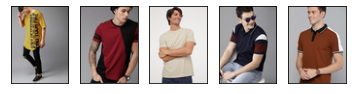

In [ ]:
#Topwear
retrieve_similar_fashion_products(np.squeeze(neighbours)[1:])

In [ ]:
#links of recommendations
for i in np.squeeze(neighbours)[1:]: 
    print(final_links_mtw.iloc[i])

https://www.myntra.com/tshirts/moda-rapido/moda-rapido-men-mustard-printed-round-neck-longline-t-shirt/5613465/buy
https://www.myntra.com/tshirts/moda-rapido/moda-rapido-men-maroon--black-colourblocked-round-neck-t-shirt/2221361/buy
https://www.myntra.com/tshirts/hm/hm-men-beige-solid-round-neck-t-shirt-regular-fit/13014142/buy
https://www.myntra.com/tshirts/herenow/herenow-men-navy-polo-collar-t-shirt/7546900/buy
https://www.myntra.com/tshirts/herenow/herenow-men-rust-brown-solid-polo-collar-t-shirt-with-striped-sleeves/12787058/buy


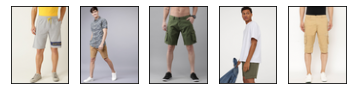

In [ ]:
#Bottomwear
retrieve_similar_fashion_products(np.squeeze(neighbours)[1:])

In [ ]:
#links of recommendations
for i in np.squeeze(neighbours)[1:]: 
    print(final_links_mbw.iloc[i])

https://www.myntra.com/shorts/united-colors-of-benetton/united-colors-of-benetton-men-grey-melange-solid-regular-fit--shorts/9695911/buy
https://www.myntra.com/shorts/highlander/highlander-men-khaki-solid-slim-fit-regular-shorts/10285709/buy
https://www.myntra.com/shorts/roadster/roadster-men-olive-green-solid-regular-fit-cargo-shorts/10944776/buy
https://www.myntra.com/shorts/hm/hm-men-green-solid-cotton-shorts/13147636/buy
https://www.myntra.com/shorts/sapper/sapper-men-mustard-solid-slim-fit-cargo-shorts/13272344/buy


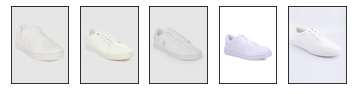

In [ ]:
#Footwear
retrieve_similar_fashion_products(np.squeeze(neighbours)[1:])

In [ ]:
#links of recommendations
for i in np.squeeze(neighbours)[1:]: 
    print(final_links_mfw.iloc[i])

https://www.myntra.com/casual-shoes/hrx-by-hrithik-roshan/hrx-by-hrithik-roshan-men-white-pro-sneaker/11567564/buy
https://www.myntra.com/casual-shoes/united-colors-of-benetton/united-colors-of-benetton-men-white-texturedsneakers/12555834/buy
https://www.myntra.com/casual-shoes/us-polo-assn/us-polo-assn-men-off-white-sneakers/13069562/buy
https://www.myntra.com/casual-shoes/sparx/sparx-men-white-solid-sneakers/10715812/buy
https://www.myntra.com/casual-shoes/highlander/highlander-men-white-solid-sneakers/11986142/buy


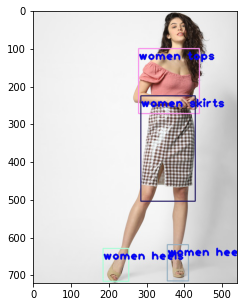

In [ ]:
#Full Image
from PIL import Image 
from numpy import asarray
from tqdm import tqdm

image_b = Image.open('full_img2.jpg')
#array=np.reshape(image_b,(1, 14400))/255.
image_b.size
plt.figure(figsize=(10, 5))
plt.imshow(image_b)

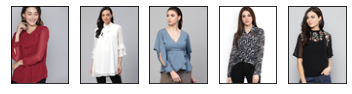

In [ ]:
#Topwear
retrieve_similar_fashion_products(np.squeeze(neighbours)[1:])

In [ ]:
#links of recommendations
for i in np.squeeze(neighbours)[1:]: 
    print(final_links_wtw.iloc[i])

https://www.myntra.com/tops/herenow/herenow-women-maroon-self-design-dobby-weave-shirt-style-top/12051498/buy
https://www.myntra.com/tops/dorothy-perkins/dorothy-perkins-women-white-tie-up-neck-solid-top/12409780/buy
https://www.myntra.com/tops/sassafras/sassafras-women-blue-solid-wrap-top/11364302/buy
https://www.myntra.com/tops/mayra/mayra-women-black-printed-shirt-style-top/7256771/buy
https://www.myntra.com/tops/harpa/harpa-women-black-solid-top-with-floral-embroidery/7578956/buy


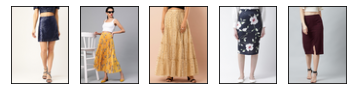

In [ ]:
#Bottomwear
retrieve_similar_fashion_products(np.squeeze(neighbours)[1:])

In [ ]:
#links of recommendations
for i in np.squeeze(neighbours)[1:]: 
    print(final_links_wbw.iloc[i])

https://www.myntra.com/skirts/20dresses/20dresses-women-navy-blue-sequinned-mini-a-line-skirt/13005566/buy
https://www.myntra.com/skirts/sassafras/sassafras-women-mustard-yellow--olive-green-printed-accordian-pleated-a-line-skirt/11364386/buy
https://www.myntra.com/skirts/indya/indya-women-beige-mukaish-mesh-tiered-maxi-skirt/12937516/buy
https://www.myntra.com/skirts/kassually/kassually-navy-blue-printed-skirt/11289006/buy
https://www.myntra.com/skirts/athena/athena-women-burgundy-solid-pencil-midi-skirt/12086086/buy


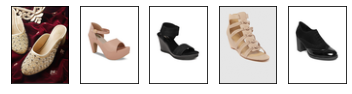

In [ ]:
#Footwear
retrieve_similar_fashion_products(np.squeeze(neighbours)[1:])

In [ ]:
#links of recommendations
for i in np.squeeze(neighbours)[1:]: 
    print(final_links_wfw.iloc[i])

https://www.myntra.com/heels/house-of-pataudi/house-of-pataudi-women-beige--silver-toned-embellished-handcrafted-heeled-mules/12306906/buy
https://www.myntra.com/heels/shoetopia/shoetopia-women-peach-coloured-solid-heels/11088050/buy
https://www.myntra.com/heels/catwalk/catwalk-women-black-solid-heels/8607635/buy
https://www.myntra.com/heels/allen-solly/allen-solly-women-beige-strappy-mid-top-gladiator-heels/8611205/buy
https://www.myntra.com/heels/catwalk/catwalk-women-black-solid-heeled-boots/8607633/buy


**Cosine Similarity**

In [161]:
x=np.concatenate((x_train,x_test))

In [162]:
#Finding cosine similarity of embeddings of fashion products
from PIL import Image
from tqdm import tqdm
from numpy import asarray
from sklearn.metrics.pairwise import cosine_similarity


cos_sim_list=[]
image_b = Image.open('img_part10.jpg')
img_array = asarray(image_b)
image_array_b = np.reshape(img_array,(1,14400))/255.
ex_b=np.expand_dims(image_array_b, axis=0)
ex_emb_b=embedding_model.predict(ex_b)[0]
d=np.squeeze(ex_emb_b)
for i in x:
    image_array_a = np.reshape(i,(1,14400))
    ex_a=np.expand_dims(image_array_a, axis=0)
    ex_emb_a=embedding_model.predict(ex_a)[0]
    c=np.squeeze(ex_emb_a)

    cos_sim_list.append(cosine_similarity(ex_emb_a,ex_emb_b))

In [163]:
#Picking the best 5 matches
y=np.argsort(np.squeeze(cos_sim_list))[-6:]

In [63]:
#Retrieving Similar fashion products
def retrieve_similar_fashion_products(y):
    plt.figure(figsize=(6, 2))
    for i in range(5):
        plt.subplot(1, 5, 1 + i)
        plt.imshow(np.reshape(x[y[i]],(80,60,3)))
        plt.xticks([])
        plt.yticks([])
    plt.show()

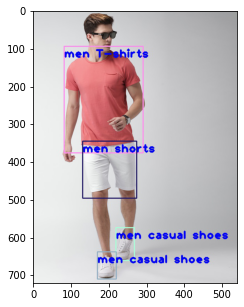

In [29]:
#Full Image
from PIL import Image 
from numpy import asarray
from tqdm import tqdm

image_b = Image.open('full_img1.jpg')
#array=np.reshape(image_b,(1, 14400))/255.
image_b.size
plt.figure(figsize=(10, 5))
plt.imshow(image_b)

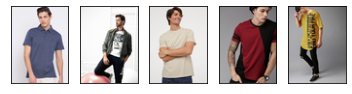

In [164]:
#Topwear
retrieve_similar_fashion_products(y[:5])

In [165]:
#links of recommendations
for i in y[:5]: 
    print(final_links_mtw.iloc[i])

https://www.myntra.com/tshirts/gant/gant-men-blue-printed-polo-collar-t-shirt/11921534/buy
https://www.myntra.com/tshirts/hrx-by-hrithik-roshan/hrx-by-hrithik-roshan-men-white-rapid-dry-camo-training-t-shirt/5842076/buy
https://www.myntra.com/tshirts/hm/hm-men-beige-solid-round-neck-t-shirt-regular-fit/13014142/buy
https://www.myntra.com/tshirts/moda-rapido/moda-rapido-men-maroon--black-colourblocked-round-neck-t-shirt/2221361/buy
https://www.myntra.com/tshirts/moda-rapido/moda-rapido-men-mustard-printed-round-neck-longline-t-shirt/5613465/buy


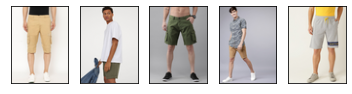

In [140]:
#Bottomwear
retrieve_similar_fashion_products(y[:5])

In [141]:
#links of recommendations
for i in y[:5]: 
    print(final_links_mbw.iloc[i])

https://www.myntra.com/shorts/sapper/sapper-men-mustard-solid-slim-fit-cargo-shorts/13272344/buy
https://www.myntra.com/shorts/hm/hm-men-green-solid-cotton-shorts/13147636/buy
https://www.myntra.com/shorts/roadster/roadster-men-olive-green-solid-regular-fit-cargo-shorts/10944776/buy
https://www.myntra.com/shorts/highlander/highlander-men-khaki-solid-slim-fit-regular-shorts/10285709/buy
https://www.myntra.com/shorts/united-colors-of-benetton/united-colors-of-benetton-men-grey-melange-solid-regular-fit--shorts/9695911/buy


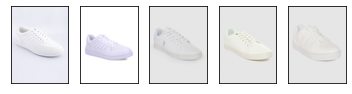

In [117]:
#Bottomwear
retrieve_similar_fashion_products(y[:5])

In [118]:
#links of recommendations
for i in y[:5]: 
    print(final_links_mfw.iloc[i])

https://www.myntra.com/casual-shoes/highlander/highlander-men-white-solid-sneakers/11986142/buy
https://www.myntra.com/casual-shoes/sparx/sparx-men-white-solid-sneakers/10715812/buy
https://www.myntra.com/casual-shoes/us-polo-assn/us-polo-assn-men-off-white-sneakers/13069562/buy
https://www.myntra.com/casual-shoes/united-colors-of-benetton/united-colors-of-benetton-men-white-texturedsneakers/12555834/buy
https://www.myntra.com/casual-shoes/hrx-by-hrithik-roshan/hrx-by-hrithik-roshan-men-white-pro-sneaker/11567564/buy


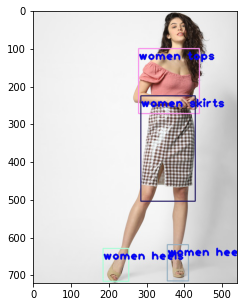

In [30]:
#Full Image
from PIL import Image 
from numpy import asarray
from tqdm import tqdm

image_b = Image.open('full_img2.jpg')
#array=np.reshape(image_b,(1, 14400))/255.
image_b.size
plt.figure(figsize=(10, 5))
plt.imshow(image_b)

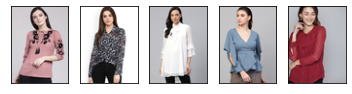

In [94]:
#Topwear
retrieve_similar_fashion_products(y[:5])

In [95]:
#links of recommendations
for i in y[:5]: 
    print(final_links_wtw.iloc[i])

https://www.myntra.com/tops/pluss/pluss-women-pink-printed-top/8392599/buy
https://www.myntra.com/tops/mayra/mayra-women-black-printed-shirt-style-top/7256771/buy
https://www.myntra.com/tops/dorothy-perkins/dorothy-perkins-women-white-tie-up-neck-solid-top/12409780/buy
https://www.myntra.com/tops/sassafras/sassafras-women-blue-solid-wrap-top/11364302/buy
https://www.myntra.com/tops/herenow/herenow-women-maroon-self-design-dobby-weave-shirt-style-top/12051498/buy


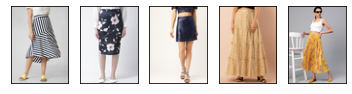

In [74]:
#Bottomwear
retrieve_similar_fashion_products(y[:5])

In [75]:
#links of recommendations
for i in y[:5]: 
    print(final_links_wbw.iloc[i])

https://www.myntra.com/skirts/vero-moda/vero-moda-women-navy-blue--white-striped-a-line-skirt/11488126/buy
https://www.myntra.com/skirts/kassually/kassually-navy-blue-printed-skirt/11289006/buy
https://www.myntra.com/skirts/20dresses/20dresses-women-navy-blue-sequinned-mini-a-line-skirt/13005566/buy
https://www.myntra.com/skirts/indya/indya-women-beige-mukaish-mesh-tiered-maxi-skirt/12937516/buy
https://www.myntra.com/skirts/sassafras/sassafras-women-mustard-yellow--olive-green-printed-accordian-pleated-a-line-skirt/11364386/buy


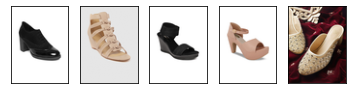

In [35]:
#Footwear
retrieve_similar_fashion_products(y[:5])

In [36]:
#links of recommendations
for i in y[:5]: 
    print(final_links_wfw.iloc[i])

https://www.myntra.com/heels/catwalk/catwalk-women-black-solid-heeled-boots/8607633/buy
https://www.myntra.com/heels/allen-solly/allen-solly-women-beige-strappy-mid-top-gladiator-heels/8611205/buy
https://www.myntra.com/heels/catwalk/catwalk-women-black-solid-heels/8607635/buy
https://www.myntra.com/heels/shoetopia/shoetopia-women-peach-coloured-solid-heels/11088050/buy
https://www.myntra.com/heels/house-of-pataudi/house-of-pataudi-women-beige--silver-toned-embellished-handcrafted-heeled-mules/12306906/buy


**Euclidean Distance**

In [166]:
#Finding euclidean distance of embeddings of fashion products

from tqdm import tqdm
from scipy.spatial import distance

euc_dist=[]
image_b = Image.open('img_part10.jpg')
img_array = asarray(image_b)
image_array_b = np.reshape(img_array,(1, 14400))/255.
#ex_b=np.expand_dims(image_array_b, axis=0)
ex_emb_b=embedding_model.predict(image_array_b)[0]
d=np.squeeze(ex_emb_b)
for i in x:
    image_array_a = np.reshape(i,(1, 14400))
    #ex_a=np.expand_dims(image_array_a, axis=0)
    ex_emb_a=embedding_model.predict(image_array_a)[0]
    c=np.squeeze(ex_emb_a)

    euc_dist.append(distance.euclidean(ex_emb_a,ex_emb_b))

In [167]:
#Picking the best 5 matches
y=np.argsort(np.squeeze(euc_dist))[:6]

In [69]:
#Retrieving the similar fashion products
def retrieve_similar_fashion_products(y):
    plt.figure(figsize=(6, 2))
    for i in range(5):
        plt.subplot(1, 5, 1 + i)
        plt.imshow(np.reshape(x[y[i]],(80,60,3)))
        plt.xticks([])
        plt.yticks([])
    plt.show()

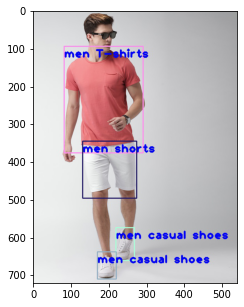

In [37]:
#Full Image
from PIL import Image 
from numpy import asarray
from tqdm import tqdm

image_b = Image.open('full_img1.jpg')
#array=np.reshape(image_b,(1, 14400))/255.
image_b.size
plt.figure(figsize=(10, 5))
plt.imshow(image_b)

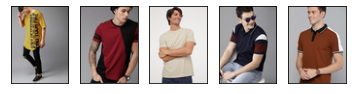

In [168]:
#Topwear
retrieve_similar_fashion_products(y[1:])

In [169]:
#links of recommendations
for i in y[1:]: 
    print(final_links_mtw.iloc[i])

https://www.myntra.com/tshirts/moda-rapido/moda-rapido-men-mustard-printed-round-neck-longline-t-shirt/5613465/buy
https://www.myntra.com/tshirts/moda-rapido/moda-rapido-men-maroon--black-colourblocked-round-neck-t-shirt/2221361/buy
https://www.myntra.com/tshirts/hm/hm-men-beige-solid-round-neck-t-shirt-regular-fit/13014142/buy
https://www.myntra.com/tshirts/herenow/herenow-men-navy-polo-collar-t-shirt/7546900/buy
https://www.myntra.com/tshirts/herenow/herenow-men-rust-brown-solid-polo-collar-t-shirt-with-striped-sleeves/12787058/buy


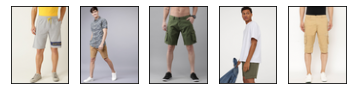

In [145]:
#Bottomwear
retrieve_similar_fashion_products(y[1:])

In [146]:
#links of recommendations
for i in y[1:]: 
    print(final_links_mbw.iloc[i])

https://www.myntra.com/shorts/united-colors-of-benetton/united-colors-of-benetton-men-grey-melange-solid-regular-fit--shorts/9695911/buy
https://www.myntra.com/shorts/highlander/highlander-men-khaki-solid-slim-fit-regular-shorts/10285709/buy
https://www.myntra.com/shorts/roadster/roadster-men-olive-green-solid-regular-fit-cargo-shorts/10944776/buy
https://www.myntra.com/shorts/hm/hm-men-green-solid-cotton-shorts/13147636/buy
https://www.myntra.com/shorts/sapper/sapper-men-mustard-solid-slim-fit-cargo-shorts/13272344/buy


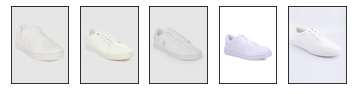

In [121]:
#Footwear
retrieve_similar_fashion_products(y[1:])

In [122]:
#links of recommendations
for i in y[1:]: 
    print(final_links_mfw.iloc[i])

https://www.myntra.com/casual-shoes/hrx-by-hrithik-roshan/hrx-by-hrithik-roshan-men-white-pro-sneaker/11567564/buy
https://www.myntra.com/casual-shoes/united-colors-of-benetton/united-colors-of-benetton-men-white-texturedsneakers/12555834/buy
https://www.myntra.com/casual-shoes/us-polo-assn/us-polo-assn-men-off-white-sneakers/13069562/buy
https://www.myntra.com/casual-shoes/sparx/sparx-men-white-solid-sneakers/10715812/buy
https://www.myntra.com/casual-shoes/highlander/highlander-men-white-solid-sneakers/11986142/buy


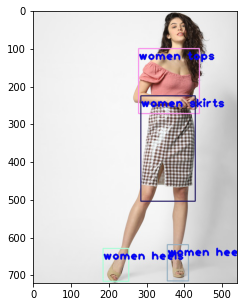

In [38]:
#Full Image
from PIL import Image 
from numpy import asarray
from tqdm import tqdm

image_b = Image.open('full_img2.jpg')
#array=np.reshape(image_b,(1, 14400))/255.
image_b.size
plt.figure(figsize=(10, 5))
plt.imshow(image_b)

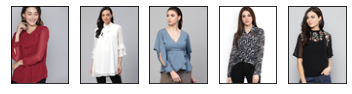

In [98]:
#Topwear
retrieve_similar_fashion_products(y[1:])

In [99]:
#links of recommendations
for i in y[1:]: 
    print(final_links_wtw.iloc[i])

https://www.myntra.com/tops/herenow/herenow-women-maroon-self-design-dobby-weave-shirt-style-top/12051498/buy
https://www.myntra.com/tops/dorothy-perkins/dorothy-perkins-women-white-tie-up-neck-solid-top/12409780/buy
https://www.myntra.com/tops/sassafras/sassafras-women-blue-solid-wrap-top/11364302/buy
https://www.myntra.com/tops/mayra/mayra-women-black-printed-shirt-style-top/7256771/buy
https://www.myntra.com/tops/harpa/harpa-women-black-solid-top-with-floral-embroidery/7578956/buy


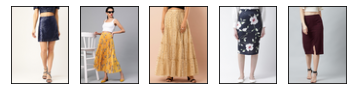

In [70]:
#Bottomwear
retrieve_similar_fashion_products(y[1:])

In [71]:
#links of recommendations
for i in y[1:]: 
    print(final_links_wbw.iloc[i])

https://www.myntra.com/skirts/20dresses/20dresses-women-navy-blue-sequinned-mini-a-line-skirt/13005566/buy
https://www.myntra.com/skirts/sassafras/sassafras-women-mustard-yellow--olive-green-printed-accordian-pleated-a-line-skirt/11364386/buy
https://www.myntra.com/skirts/indya/indya-women-beige-mukaish-mesh-tiered-maxi-skirt/12937516/buy
https://www.myntra.com/skirts/kassually/kassually-navy-blue-printed-skirt/11289006/buy
https://www.myntra.com/skirts/athena/athena-women-burgundy-solid-pencil-midi-skirt/12086086/buy


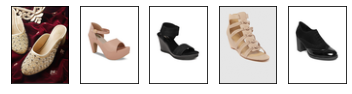

In [43]:
#Topwear
retrieve_similar_fashion_products(y[1:])

In [44]:
#links of recommendations
for i in y[1:]: 
    print(final_links_wfw.iloc[i])

https://www.myntra.com/heels/house-of-pataudi/house-of-pataudi-women-beige--silver-toned-embellished-handcrafted-heeled-mules/12306906/buy
https://www.myntra.com/heels/shoetopia/shoetopia-women-peach-coloured-solid-heels/11088050/buy
https://www.myntra.com/heels/catwalk/catwalk-women-black-solid-heels/8607635/buy
https://www.myntra.com/heels/allen-solly/allen-solly-women-beige-strappy-mid-top-gladiator-heels/8611205/buy
https://www.myntra.com/heels/catwalk/catwalk-women-black-solid-heeled-boots/8607633/buy
